In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Found 5556 images.


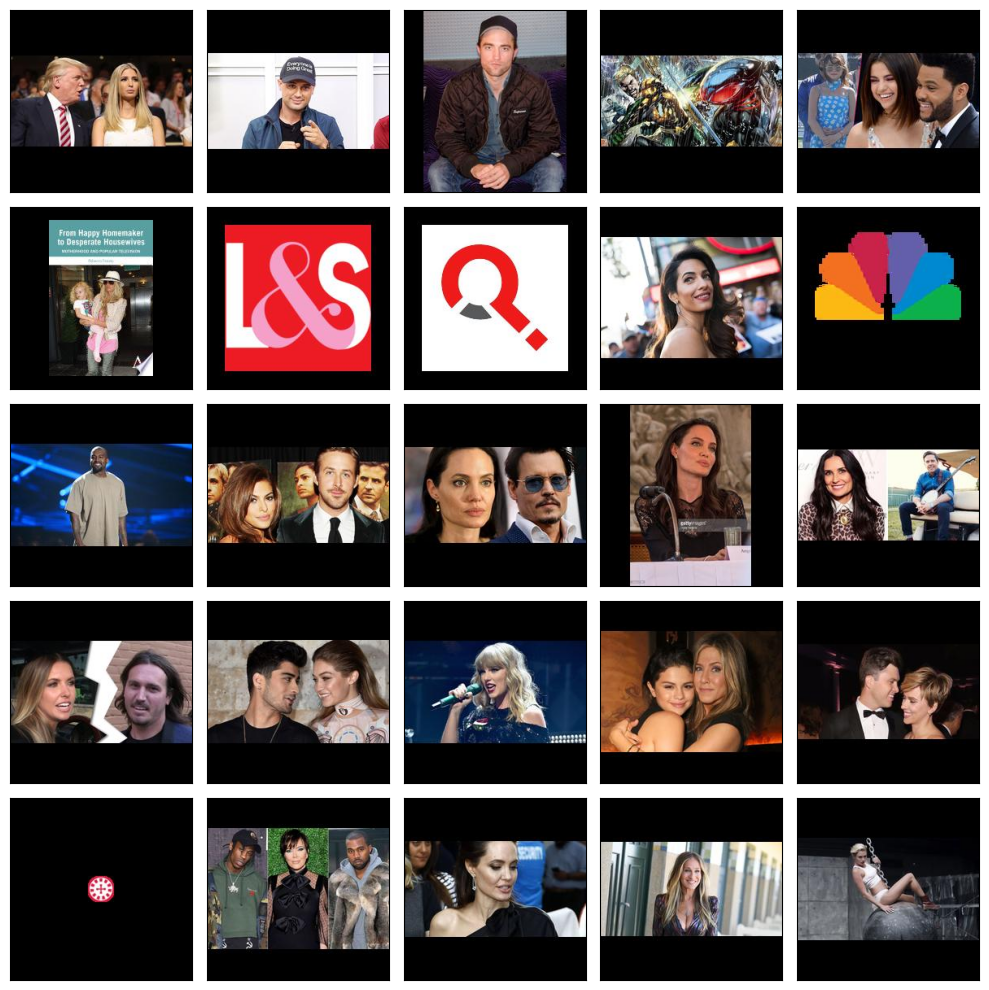

In [3]:
import matplotlib.pyplot as plt
from PIL import Image
import os

# Path to your folder containing subfolders with images
preview_folder = "/content/drive/MyDrive/ann images"

# Recursively find all image files in the subfolders
image_files = []
for root, _, files in os.walk(preview_folder):
    for file in files:
        if file.lower().endswith(('.jpg', '.png', '.jpeg')):  # Add more extensions if needed
            image_files.append(os.path.join(root, file))

print(f"Found {len(image_files)} images.")

# Create a 5x5 grid to display up to 25 images
plt.figure(figsize=[10, 10])

for i in range(min(25, len(image_files))):  # Display up to 25 images
    plt.subplot(5, 5, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)

    try:
        img = Image.open(image_files[i])
        plt.imshow(img)  # Show images in color
    except Exception as e:
        print(f"Error displaying image {image_files[i]}: {e}")

plt.tight_layout()
plt.show()


In [4]:
import os
import glob
import pandas as pd

# Set paths
image_base_path = '/content/drive/MyDrive/ann images'  # e.g., '/project/images'
csv_file = '/content/filtered_dataset_clean.csv'

# Check folder existence
label_0_path = os.path.join(image_base_path, 'label_0')
label_1_path = os.path.join(image_base_path, 'label_1')
print(f"Image base path exists: {os.path.exists(image_base_path)}")
print(f"label_0 folder exists: {os.path.exists(label_0_path)}")
print(f"label_1 folder exists: {os.path.exists(label_1_path)}")

# List contents
if os.path.exists(label_0_path):
    print(f"label_0 (fake) contents: {os.listdir(label_0_path)[:5]}")
else:
    print("label_0 folder not found")
if os.path.exists(label_1_path):
    print(f"label_1 (real) contents: {os.listdir(label_1_path)[:5]}")
else:
    print("label_1 folder not found")

# Count images (jpg, jpeg, png)
label_0_images = glob.glob(os.path.join(image_base_path, 'label_0', '*.[jJ][pP][gG]')) + \
                 glob.glob(os.path.join(image_base_path, 'label_0', '*.[jJ][pP][eE][gG]')) + \
                 glob.glob(os.path.join(image_base_path, 'label_0', '*.[pP][nN][gG]'))
label_1_images = glob.glob(os.path.join(image_base_path, 'label_1', '*.[jJ][pP][gG]')) + \
                 glob.glob(os.path.join(image_base_path, 'label_1', '*.[jJ][pP][eE][gG]')) + \
                 glob.glob(os.path.join(image_base_path, 'label_1', '*.[pP][nN][gG]'))

print(f"label_0 (fake) images: {len(label_0_images)}")
print(f"label_1 (real) images: {len(label_1_images)}")
if label_0_images:
    print(f"Sample label_0 images: {label_0_images[:5]}")
if label_1_images:
    print(f"Sample label_1 images: {label_1_images[:5]}")

# Check CSV
data = pd.read_csv(csv_file)
fake_count = len(data[data['label'] == 0])
real_count = len(data[data['label'] == 1])
print(f"Fake CSV rows (label=0): {fake_count}")
print(f"Real CSV rows (label=1): {real_count}")

# Warn if insufficient images
if len(label_0_images) < fake_count or len(label_1_images) < real_count:
    print("Warning: Not enough images. Will cycle through available images.")
if len(label_0_images) == 0 or len(label_1_images) == 0:
    print("Error: No images found in one or both subfolders. Check paths, extensions, or permissions.")

Image base path exists: True
label_0 folder exists: True
label_1 folder exists: True
label_0 (fake) contents: ['image_2445.jpg', 'image_527.jpg', 'image_946.jpg', 'image_1693.jpg', 'image_902.jpg']
label_1 (real) contents: ['image_4261.jpg', 'image_3534.jpg', 'image_4523.jpg', 'image_4192.jpg', 'image_5709.jpg']
label_0 (fake) images: 2778
label_1 (real) images: 2778
Sample label_0 images: ['/content/drive/MyDrive/ann images/label_0/image_2445.jpg', '/content/drive/MyDrive/ann images/label_0/image_527.jpg', '/content/drive/MyDrive/ann images/label_0/image_946.jpg', '/content/drive/MyDrive/ann images/label_0/image_1693.jpg', '/content/drive/MyDrive/ann images/label_0/image_902.jpg']
Sample label_1 images: ['/content/drive/MyDrive/ann images/label_1/image_4261.jpg', '/content/drive/MyDrive/ann images/label_1/image_3534.jpg', '/content/drive/MyDrive/ann images/label_1/image_4523.jpg', '/content/drive/MyDrive/ann images/label_1/image_4192.jpg', '/content/drive/MyDrive/ann images/label_1/im

In [5]:
from PIL import Image

try:
    label_0_img = Image.open(os.path.join(image_base_path, 'label_0', os.listdir(label_0_path)[0]))
    print("label_0 (fake) image loaded successfully")
except Exception as e:
    print(f"Failed to load label_0 image: {e}")
try:
    label_1_img = Image.open(os.path.join(image_base_path, 'label_1', os.listdir(label_1_path)[0]))
    print("label_1 (real) image loaded successfully")
except Exception as e:
    print(f"Failed to load label_1 image: {e}")

label_0 (fake) image loaded successfully
label_1 (real) image loaded successfully


In [13]:
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from transformers import CLIPProcessor
import os
import glob
import random

class NewsDataset(Dataset):
    def __init__(self, csv_file, processor, image_base_path):
        self.data = pd.read_csv(csv_file)
        self.processor = processor
        self.image_base_path = image_base_path

        # Load image paths
        self.fake_images = glob.glob(os.path.join(image_base_path, 'label_0', '*.[jJ][pP][gG]')) + \
                          glob.glob(os.path.join(image_base_path, 'label_0', '*.[jJ][pP][eE][gG]')) + \
                          glob.glob(os.path.join(image_base_path, 'label_0', '*.[pP][nN][gG]')) + \
                          glob.glob(os.path.join(image_base_path, 'label_0', '*.[wW][eE][bB][pP]'))
        self.real_images = glob.glob(os.path.join(image_base_path, 'label_1', '*.[jJ][pP][gG]')) + \
                          glob.glob(os.path.join(image_base_path, 'label_1', '*.[jJ][pP][eE][gG]')) + \
                          glob.glob(os.path.join(image_base_path, 'label_1', '*.[pP][nN][gG]')) + \
                          glob.glob(os.path.join(image_base_path, 'label_1', '*.[wW][eE][bB][pP]'))

        # Check images
        if not self.fake_images or not self.real_images:
            raise ValueError("No images found in label_0/ or label_1/. Check paths, extensions, or permissions.")

        random.shuffle(self.fake_images)
        random.shuffle(self.real_images)
        print(f"Loaded {len(self.fake_images)} fake images (label_0), {len(self.real_images)} real images (label_1)")

        fake_count = len(self.data[self.data['label'] == 0])
        real_count = len(self.data[self.data['label'] == 1])
        if len(self.fake_images) < fake_count or len(self.real_images) < real_count:
            print("Warning: Not enough images. Will cycle through available images.")

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        text = self.data.iloc[idx]['text']
        label = self.data.iloc[idx]['label']

        # Select image
        if label == 0:  # Fake
            image_path = self.fake_images[idx % len(self.fake_images)]
        else:  # Real
            image_path = self.real_images[idx % len(self.real_images)]

        # Load image
        try:
            image = Image.open(image_path).convert('RGB')
        except Exception as e:
            print(f"Failed to load image {image_path}: {e}")
            raise

        # Process text and image
        inputs = self.processor(text=text, images=image, return_tensors="pt", padding=True, truncation=True)

        # Squeeze extra batch dimension
        return {
            'pixel_values': inputs['pixel_values'].squeeze(0),  # [C, H, W]
            'input_ids': inputs['input_ids'].squeeze(0),  # [seq_len]
            'attention_mask': inputs['attention_mask'].squeeze(0),  # [seq_len]
            'label': torch.tensor(label, dtype=torch.float32)
        }

# Load processor
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
processor.image_processor.size = {"height": 160, "width": 160}  # CPU optimization
processor.max_length = 50  # Short text

# Set paths
image_base_path = '/content/drive/MyDrive/ann images'  # e.g., '/project/images'
csv_file = '/content/filtered_dataset_clean.csv'

# Instantiate the dataset
dataset = NewsDataset(csv_file, processor, image_base_path)

# Calculate sizes for splits
train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size

# Perform the splits
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(
    dataset, [train_size, val_size, test_size]
)


# CPU-optimized dataloader
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=0)

Loaded 2778 fake images (label_0), 2778 real images (label_1)


In [7]:
import torch
import torch.nn as nn
from torch.optim import AdamW
from sklearn.metrics import accuracy_score, f1_score
from transformers import CLIPModel
import gc

# Model definition
class CLIPClassifier(nn.Module):
    def __init__(self, clip_model):
        super(CLIPClassifier, self).__init__()
        self.clip = clip_model
        self.classifier = nn.Sequential(
            nn.Linear(1024, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 1)
        )

    def forward(self, pixel_values, input_ids, attention_mask):
        outputs = self.clip(pixel_values=pixel_values, input_ids=input_ids, attention_mask=attention_mask)
        image_embeds = outputs.image_embeds
        text_embeds = outputs.text_embeds
        fused_embeds = torch.cat((image_embeds, text_embeds), dim=-1)
        logits = self.classifier(fused_embeds)
        return logits

# Load model
clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
model = CLIPClassifier(clip_model)

# Freeze CLIP parameters
for param in model.clip.parameters():
    param.requires_grad = False

# Enable training for classifier parameters
for param in model.classifier.parameters():
    param.requires_grad = True

# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
model.to(device)

# Optimizer and loss
optimizer = AdamW(model.parameters(), lr=2e-5)
criterion = nn.BCEWithLogitsLoss()

# Training parameters
num_epochs = 7
accumulation_steps = 4

# Debugging DataLoader
try:
    print(f"Number of batches in train_loader: {len(train_loader)}")
except Exception as e:
    print(f"Error with train_loader: {e}")

try:
    print(f"Number of batches in val_loader: {len(val_loader)}")
except Exception as e:
    print(f"Error with val_loader: {e}")

# Training loop
for epoch in range(num_epochs):
    model.train()
    train_loss = 0

    print(f"Starting epoch {epoch + 1}...")
    for i, batch in enumerate(train_loader):
        try:
            pixel_values = batch['pixel_values'].to(device)
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            # Forward pass
            logits = model(pixel_values, input_ids, attention_mask).squeeze(-1)
            loss = criterion(logits, labels)
            loss = loss / accumulation_steps
            loss.backward()

            # Gradient accumulation
            if (i + 1) % accumulation_steps == 0:
                optimizer.step()
                optimizer.zero_grad()

            train_loss += loss.item() * accumulation_steps

        except Exception as e:
            print(f"Error during training at batch {i}: {e}")
            break  # Optional: stop training on error

    print(f"Epoch {epoch + 1}, Train Loss: {train_loss / len(train_loader):.4f}")

    # Validation
    model.eval()
    val_preds, val_labels = [], []
    with torch.no_grad():
        for j, batch in enumerate(val_loader):
            try:
                pixel_values = batch['pixel_values'].to(device)
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                labels = batch['label'].to(device)

                logits = model(pixel_values, input_ids, attention_mask).squeeze(-1)
                preds = torch.sigmoid(logits) > 0.5
                val_preds.extend(preds.cpu().numpy())
                val_labels.extend(labels.cpu().numpy())

            except Exception as e:
                print(f"Error during validation at batch {j}: {e}")
                break

    try:
        val_accuracy = accuracy_score(val_labels, val_preds)
        val_f1 = f1_score(val_labels, val_preds)
        print(f"Validation Accuracy: {val_accuracy:.4f}, F1-Score: {val_f1:.4f}")
    except Exception as e:
        print(f"Error calculating validation metrics: {e}")

    # Memory cleanup
    gc.collect()


Using device: cuda
Number of batches in train_loader: 3889
Number of batches in val_loader: 833
Starting epoch 1...
Epoch 1, Train Loss: 0.6901
Validation Accuracy: 0.6963, F1-Score: 0.6567
Starting epoch 2...
Epoch 2, Train Loss: 0.6789
Validation Accuracy: 0.7383, F1-Score: 0.7268
Starting epoch 3...
Epoch 3, Train Loss: 0.6620
Validation Accuracy: 0.7383, F1-Score: 0.7572
Starting epoch 4...
Epoch 4, Train Loss: 0.6418
Validation Accuracy: 0.7527, F1-Score: 0.7616
Starting epoch 5...
Epoch 5, Train Loss: 0.6197
Validation Accuracy: 0.7479, F1-Score: 0.7603
Starting epoch 6...
Epoch 6, Train Loss: 0.5984
Validation Accuracy: 0.7491, F1-Score: 0.7628
Starting epoch 7...
Epoch 7, Train Loss: 0.5779
Validation Accuracy: 0.7551, F1-Score: 0.7728


In [9]:
import torch
import torch.nn as nn
from torch.optim import AdamW
from sklearn.metrics import accuracy_score, f1_score
from transformers import CLIPModel
import gc

class CLIPClassifier(nn.Module):
    def __init__(self, clip_model):
        super(CLIPClassifier, self).__init__()
        self.clip = clip_model
        self.classifier = nn.Sequential(
            nn.Linear(1024, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 1)
        )

    def forward(self, pixel_values, input_ids, attention_mask):
        outputs = self.clip(pixel_values=pixel_values, input_ids=input_ids, attention_mask=attention_mask)
        image_embeds = outputs.image_embeds
        text_embeds = outputs.text_embeds
        fused_embeds = torch.cat((image_embeds, text_embeds), dim=-1)
        logits = self.classifier(fused_embeds)
        return logits

clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
model = CLIPClassifier(clip_model)

for param in model.clip.parameters():
    param.requires_grad = False

for param in model.classifier.parameters():
    param.requires_grad = True

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
model.to(device)

optimizer = AdamW(model.parameters(), lr=2e-5)
criterion = nn.BCEWithLogitsLoss()

num_epochs = 10
accumulation_steps = 4

try:
    print(f"Number of batches in train_loader: {len(train_loader)}")
except Exception as e:
    print(f"Error with train_loader: {e}")

try:
    print(f"Number of batches in val_loader: {len(val_loader)}")
except Exception as e:
    print(f"Error with val_loader: {e}")

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    train_preds = []
    train_labels = []

    print(f"Starting epoch {epoch + 1}...")

    for i, batch in enumerate(train_loader):
        try:
            pixel_values = batch['pixel_values'].to(device)
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device).float()

            logits = model(pixel_values, input_ids, attention_mask).squeeze(-1)
            loss = criterion(logits, labels)
            loss = loss / accumulation_steps
            loss.backward()

            if (i + 1) % accumulation_steps == 0:
                optimizer.step()
                optimizer.zero_grad()

            train_loss += loss.item() * accumulation_steps

            # Store predictions and labels for accuracy
            preds = (torch.sigmoid(logits) > 0.5).cpu().detach().numpy()
            train_preds.extend(preds)
            train_labels.extend(labels.cpu().detach().numpy())

        except Exception as e:
            print(f"Error during training at batch {i}: {e}")
            break

    train_accuracy = accuracy_score(train_labels, train_preds)
    print(f"Epoch {epoch + 1}, Train Loss: {train_loss / len(train_loader):.4f}, Train Accuracy: {train_accuracy:.4f}")

    model.eval()
    val_preds, val_labels = [], []
    with torch.no_grad():
        for j, batch in enumerate(val_loader):
            try:
                pixel_values = batch['pixel_values'].to(device)
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                labels = batch['label'].to(device).float()

                logits = model(pixel_values, input_ids, attention_mask).squeeze(-1)
                preds = (torch.sigmoid(logits) > 0.5).cpu().numpy()
                val_preds.extend(preds)
                val_labels.extend(labels.cpu().numpy())

            except Exception as e:
                print(f"Error during validation at batch {j}: {e}")
                break

    try:
        val_accuracy = accuracy_score(val_labels, val_preds)
        val_f1 = f1_score(val_labels, val_preds)
        print(f"Validation Accuracy: {val_accuracy:.4f}, F1-Score: {val_f1:.4f}")
    except Exception as e:
        print(f"Error calculating validation metrics: {e}")

    gc.collect()

# Test evaluation (optional)
if 'test_loader' in globals():
    print("Starting test evaluation...")
    model.eval()
    test_preds, test_labels = [], []
    with torch.no_grad():
        for k, batch in enumerate(test_loader):
            try:
                pixel_values = batch['pixel_values'].to(device)
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                labels = batch['label'].to(device).float()

                logits = model(pixel_values, input_ids, attention_mask).squeeze(-1)
                preds = (torch.sigmoid(logits) > 0.5).cpu().numpy()
                test_preds.extend(preds)
                test_labels.extend(labels.cpu().numpy())

            except Exception as e:
                print(f"Error during test evaluation at batch {k}: {e}")
                break

    try:
        test_accuracy = accuracy_score(test_labels, test_preds)
        test_f1 = f1_score(test_labels, test_preds)
        print(f"Test Accuracy: {test_accuracy:.4f}, Test F1-Score: {test_f1:.4f}")
    except Exception as e:
        print(f"Error calculating test metrics: {e}")
else:
    print("No test_loader found. Skipping test evaluation.")


Using device: cuda
Number of batches in train_loader: 3889
Number of batches in val_loader: 833
Starting epoch 1...
Epoch 1, Train Loss: 0.6893, Train Accuracy: 0.5629
Validation Accuracy: 0.5498, F1-Score: 0.2775
Starting epoch 2...
Epoch 2, Train Loss: 0.6773, Train Accuracy: 0.6719
Validation Accuracy: 0.7431, F1-Score: 0.7345
Starting epoch 3...
Epoch 3, Train Loss: 0.6594, Train Accuracy: 0.7480
Validation Accuracy: 0.7407, F1-Score: 0.7605
Starting epoch 4...
Epoch 4, Train Loss: 0.6378, Train Accuracy: 0.7598
Validation Accuracy: 0.7419, F1-Score: 0.7576
Starting epoch 5...
Epoch 5, Train Loss: 0.6156, Train Accuracy: 0.7601
Validation Accuracy: 0.7419, F1-Score: 0.7576
Starting epoch 6...
Epoch 6, Train Loss: 0.5930, Train Accuracy: 0.7629
Validation Accuracy: 0.7503, F1-Score: 0.7598
Starting epoch 7...
Epoch 7, Train Loss: 0.5730, Train Accuracy: 0.7699
Validation Accuracy: 0.7527, F1-Score: 0.7610
Starting epoch 8...
Epoch 8, Train Loss: 0.5539, Train Accuracy: 0.7722
Valida

In [ ]:
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from transformers import CLIPProcessor
import os
import glob
import random
import torch.nn as nn
from torch.optim import AdamW
from sklearn.metrics import accuracy_score, f1_score
from transformers import CLIPModel

# Model definition
class CLIPClassifier(nn.Module):
    def __init__(self, clip_model):
        super(CLIPClassifier, self).__init__()
        self.clip = clip_model
        self.classifier = nn.Sequential(
            nn.Linear(1024, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 1)
        )

    def forward(self, pixel_values, input_ids, attention_mask):
        outputs = self.clip(pixel_values=pixel_values,
                            input_ids=input_ids,
                            attention_mask=attention_mask)
        image_embeds = outputs.image_embeds
        text_embeds = outputs.text_embeds
        fused_embeds = torch.cat((image_embeds, text_embeds), dim=-1)
        logits = self.classifier(fused_embeds)
        return logits


# Define the predict_news function
def predict_news(image_path, text, model, processor, device):
    try:
        image = Image.open(image_path).convert('RGB')
    except Exception as e:
        print(f"Failed to load image {image_path}: {e}")
        return None

    inputs = processor(text=text,
                       images=image,
                       return_tensors="pt",
                       padding=True,
                       truncation=True)
    pixel_values = inputs['pixel_values'].to(device)
    input_ids = inputs['input_ids'].to(device)
    attention_mask = inputs['attention_mask'].to(device)

    model.eval()
    with torch.no_grad():
        logits = model(pixel_values, input_ids, attention_mask).squeeze(-1)
        prob = torch.sigmoid(logits).item()
        prediction = 1 if prob > 0.5 else 0
        label = "Real" if prediction == 1 else "Fake"

    return {"label": label, "probability": prob}


# Load processor and model
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
processor.image_processor.size = {"height": 160, "width": 160}  # CPU optimization
processor.max_length = 50  # Short text

clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
model = CLIPClassifier(clip_model)

# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
model.to(device)

# Example usage
new_image_path = 'car.jpg'  # Update
new_text = "Example news headline or content"  # Update
result = predict_news(new_image_path, new_text, model, processor, device)
if result:
    print(f"Prediction: {result['label']}, Probability: {result['probability']:.4f}")

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/862k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.19k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/605M [00:00<?, ?B/s]

Using device: cpu
Prediction: Fake, Probability: 0.4850


In [15]:
print("Evaluating training accuracy...")
model.eval()
train_eval_preds, train_eval_labels = [], []

with torch.no_grad():
    for i, batch in enumerate(train_loader):
        try:
            pixel_values = batch['pixel_values'].to(device)
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device).float()

            logits = model(pixel_values, input_ids, attention_mask).squeeze(-1)
            preds = (torch.sigmoid(logits) > 0.5).cpu().numpy()

            train_eval_preds.extend(preds)
            train_eval_labels.extend(labels.cpu().numpy())

        except Exception as e:
            print(f"Error during training accuracy eval at batch {i}: {e}")
            break

try:
    train_accuracy = accuracy_score(train_eval_labels, train_eval_preds)
    train_f1 = f1_score(train_eval_labels, train_eval_preds)
    print(f"Training Accuracy: {train_accuracy:.4f}, Training F1-Score: {train_f1:.4f}")
except Exception as e:
    print(f"Error calculating training accuracy metrics: {e}")


Evaluating training accuracy...
Training Accuracy: 0.7681, Training F1-Score: 0.7739


In [14]:
print("Starting test evaluation...")
model.eval()
test_preds, test_labels = [], []

with torch.no_grad():
    for k, batch in enumerate(test_loader):
        try:
            pixel_values = batch['pixel_values'].to(device)
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device).float()

            logits = model(pixel_values, input_ids, attention_mask).squeeze(-1)
            preds = (torch.sigmoid(logits) > 0.5).cpu().numpy()

            test_preds.extend(preds)
            test_labels.extend(labels.cpu().numpy())

        except Exception as e:
            print(f"Error during test evaluation at batch {k}: {e}")
            break

try:
    test_accuracy = accuracy_score(test_labels, test_preds)
    test_f1 = f1_score(test_labels, test_preds)
    print(f"Test Accuracy: {test_accuracy:.4f}, Test F1-Score: {test_f1:.4f}")
except Exception as e:
    print(f"Error calculating test metrics: {e}")


Starting test evaluation...
Test Accuracy: 0.7854, Test F1-Score: 0.7926
